In [1]:
import geopandas as gpd
import pandas as pd
import rioxarray
import rasterio as rio
import xarray as xr
from pystac_client import Client
from datetime import datetime
from shapely.geometry import Point, Polygon, shape, box
from geopandas import GeoDataFrame
from pandas import DataFrame
import geopandas as gpd
import numpy as np
import stackstac
from dask.distributed import Client as c

In [3]:
# Selecting the locatiom
long_lat = (77.59722233643667, 12.95646688363659)
poi = Point(long_lat)

In [4]:
# Initialize STAC Client
import planetary_computer
api_url = "https://planetarycomputer.microsoft.com/api/stac/v1"
catalog = Client.open(api_url,modifier=planetary_computer.sign_inplace)

# Define parameters
start_date = "2023-06-01"
end_date = "2024-12-10"
collections = ["sentinel-2-l2a", "landsat-c2-l2"]

# Search both collections
search = catalog.search(
    collections=collections,
    datetime=f"{start_date}/{end_date}",
    intersects = poi,
    max_items=100,query={"eo:cloud_cover": {"lt": 10}},
)
items = list(search.items())

In [5]:
# for i in catalog.get_all_collections():
#     print(i)

In [6]:
results = []

# Process items
for item in items:
    date = datetime.fromisoformat(item.properties["datetime"]).strftime("%Y-%m-%d")
    results.append({
        "date": date,
        "satellite": "Sentinel-2" if "sentinel" in item.collection_id else "Landsat-8",
        "scene_id": item.id,
        "geometry": shape(item.geometry),
        "collection": item.collection_id
    })

# Create DataFrame
df = pd.DataFrame(results)
gdf = gpd.GeoDataFrame(df, geometry="geometry", crs="EPSG:4326")

# Find overlapping scenes
overlapping_pairs = []
sentinel_gdf = gdf[gdf["satellite"] == "Sentinel-2"]
landsat_gdf = gdf[gdf["satellite"] == "Landsat-8"]

for _, s2_row in sentinel_gdf.iterrows():
    for _, l8_row in landsat_gdf.iterrows():
        if s2_row["date"] == l8_row["date"]:
            if s2_row.geometry.intersects(l8_row.geometry):
                intersection = s2_row.geometry.intersection(l8_row.geometry)
                overlapping_pairs.append({
                    "date": s2_row["date"],
                    "sentinel_id": s2_row["scene_id"],
                    "landsat_id": l8_row["scene_id"],
                    "geometry": intersection
                })

# Create final GeoDataFrame
overlap_gdf = gpd.GeoDataFrame(
    overlapping_pairs,
    geometry="geometry",
    crs="EPSG:4326"
).sort_values("date").reset_index(drop=True)

# Add area in km² column
overlap_gdf["area_km2"] = overlap_gdf.to_crs("EPSG:3857").geometry.area / 10**6

# Selecting AOI with maximum overlap
Final_aoi = overlap_gdf[overlap_gdf["area_km2"]==overlap_gdf["area_km2"].max()]

# Display results
print(f"Found {len(overlap_gdf)} overlapping pairs")
print(overlap_gdf[["date", "sentinel_id", "landsat_id", "area_km2"]])

Found 3 overlapping pairs
         date                                        sentinel_id  \
0  2024-02-07  S2A_MSIL2A_20240207T051001_R019_T43PGQ_2024020...   
1  2024-03-18  S2A_MSIL2A_20240318T050651_R019_T43PGQ_2024031...   
2  2024-04-27  S2A_MSIL2A_20240427T050651_R019_T43PGQ_2024042...   

                        landsat_id      area_km2  
0  LC08_L2SP_144051_20240207_02_T1  12565.205274  
1  LC09_L2SP_144051_20240318_02_T1  12646.282804  
2  LC08_L2SP_144051_20240427_02_T1  12654.212918  


In [5]:
Final_aoi.explore()

In [7]:
print(overlap_gdf[["date", "sentinel_id", "landsat_id", "area_km2"]])

         date                                        sentinel_id  \
0  2024-02-07  S2A_MSIL2A_20240207T051001_R019_T43PGQ_2024020...   
1  2024-03-18  S2A_MSIL2A_20240318T050651_R019_T43PGQ_2024031...   
2  2024-04-27  S2A_MSIL2A_20240427T050651_R019_T43PGQ_2024042...   

                        landsat_id      area_km2  
0  LC08_L2SP_144051_20240207_02_T1  12565.205274  
1  LC09_L2SP_144051_20240318_02_T1  12646.282804  
2  LC08_L2SP_144051_20240427_02_T1  12654.212918  


In [9]:
overlap_gdf

,date,sentinel_id,landsat_id,geometry,area_km2
0,2024-02-07,S2A_MSIL2A_20240207T051001_R019_T43PGQ_2024020...,LC08_L2SP_144051_20240207_02_T1,"POLYGON ((76.8697 13.28471, 76.90306 13.43336,...",12565.205274
1,2024-03-18,S2A_MSIL2A_20240318T050651_R019_T43PGQ_2024031...,LC09_L2SP_144051_20240318_02_T1,"POLYGON ((76.8558 13.30477, 76.88895 13.45335,...",12646.282804
2,2024-04-27,S2A_MSIL2A_20240427T050651_R019_T43PGQ_2024042...,LC08_L2SP_144051_20240427_02_T1,"POLYGON ((76.87795 13.41332, 76.91069 13.56102...",12654.212918


In [8]:
Final_aoi

,date,sentinel_id,landsat_id,geometry,area_km2
2,2024-04-27,S2A_MSIL2A_20240427T050651_R019_T43PGQ_2024042...,LC08_L2SP_144051_20240427_02_T1,"POLYGON ((76.87795 13.41332, 76.91069 13.56102...",12654.212918


In [10]:
# Searching Sentinel collection
search = catalog.search(
    collections=collections[0],
    datetime=f"{start_date}/{end_date}",
    intersects = poi,
)
sentinel_items = list(search.items())

In [11]:
# Searching Landsat collection
search = catalog.search(
collections=collections[1],
datetime=f"{start_date}/{end_date}",
    intersects = poi,
)
landsat_items = list(search.items())

In [12]:
# Fetching the UTM crs
crs = int(Final_aoi.estimate_utm_crs().to_string().split(':')[1])

In [13]:
# coinciding_date = Final_aoi.date.values[0]
coinciding_date = '2024-03-18'

In [14]:
# Converting the collection to STAC
sentinel_stack = stackstac.stack(sentinel_items,resolution=10,rescale=False,fill_value=np.nan,epsg=crs).rio.clip(Final_aoi.geometry.values, Final_aoi.crs)
landsat_stack = stackstac.stack(landsat_items, rescale=False,fill_value=np.nan,epsg=crs).rio.clip(Final_aoi.geometry.values, Final_aoi.crs)

In [15]:
# Formula for converting DN to temperature
# ST = (DN * 0.00341802) + 149.0

In [16]:
landsat_bands = ['lwir11']
sentinel_bands = ['B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B09',
       'B11', 'B12', 'B8A']

In [17]:
# Selecting the intersecting Bands from both collection
landsat_stack_sub = (landsat_stack.sel(time=coinciding_date).sel(band=landsat_bands).squeeze(dim='time').compute() * 0.00341802) + 149.0
sentinel_stack_sub = sentinel_stack.sel(time=coinciding_date,band=sentinel_bands).squeeze(dim='time').compute()

In [18]:
celsius = landsat_stack_sub - 273.15
# celsius.plot(cmap="magma", size=10,robust=True)

In [19]:
import xgboost as xgb

# -----------------------------
# 1. Load XGBoost model
# -----------------------------
model = xgb.XGBRegressor()
model.load_model(r"D:\DeepLearning\Projects\temperature_at10m\model\temp_99_61.json")
print("Model loaded.")


Model loaded.


In [20]:
# -----------------------------
# 3. Prepare data for model
# -----------------------------
# Reshape to (pixels, bands)
bands = ['B01', 'B02', 'B03', 'B08', 'B09', 'B11', 'B12', 'B8A']
data = sentinel_stack_sub.sel(band=bands)
stacked = data.transpose("y", "x", "band").values  # shape: (H, W, C)
h, w, c = stacked.shape
X = stacked.reshape(-1, c)

In [21]:
# -----------------------------
# 4. Run inference
# -----------------------------
y_pred = model.predict(X)  # shape: (H*W,)

# Reshape prediction back to (H, W)
prediction_map = y_pred.reshape(h, w)

# Wrap into xarray for georeferencing
pred_da = xr.DataArray(
    prediction_map,
    coords={"y": data.y, "x": data.x},
    dims=("y", "x"),
    name="temperature"
)
pred_da.rio.write_crs(f"EPSG:{crs}", inplace=True)  # Example UTM zone, modify as needed

<xarray.DataArray 'temperature' (y: 10979, x: 10979)> Size: 482MB
array([[321.4451 , 321.4451 , 321.4451 , ..., 318.2061 , 319.63568,
        319.6338 ],
       [321.4451 , 321.4451 , 321.4451 , ..., 318.06592, 320.8632 ,
        320.2537 ],
       [321.4451 , 321.4451 , 321.4451 , ..., 318.0569 , 320.74185,
        320.7816 ],
       ...,
       [320.20258, 317.8856 , 317.22375, ..., 324.82578, 324.31702,
        324.44543],
       [318.32263, 317.74017, 317.07834, ..., 324.71347, 324.49435,
        324.78677],
       [319.1084 , 317.32068, 316.9135 , ..., 324.49948, 324.77155,
        323.81628]], dtype=float32)
Coordinates:
  * y            (y) float64 88kB 1.5e+06 1.5e+06 1.5e+06 ... 1.39e+06 1.39e+06
  * x            (x) float64 88kB 7e+05 7e+05 7e+05 ... 8.097e+05 8.098e+05
    spatial_ref  int64 8B 0

In [22]:
pred_da

<xarray.DataArray 'temperature' (y: 10979, x: 10979)> Size: 482MB
array([[321.4451 , 321.4451 , 321.4451 , ..., 318.2061 , 319.63568,
        319.6338 ],
       [321.4451 , 321.4451 , 321.4451 , ..., 318.06592, 320.8632 ,
        320.2537 ],
       [321.4451 , 321.4451 , 321.4451 , ..., 318.0569 , 320.74185,
        320.7816 ],
       ...,
       [320.20258, 317.8856 , 317.22375, ..., 324.82578, 324.31702,
        324.44543],
       [318.32263, 317.74017, 317.07834, ..., 324.71347, 324.49435,
        324.78677],
       [319.1084 , 317.32068, 316.9135 , ..., 324.49948, 324.77155,
        323.81628]], dtype=float32)
Coordinates:
  * y            (y) float64 88kB 1.5e+06 1.5e+06 1.5e+06 ... 1.39e+06 1.39e+06
  * x            (x) float64 88kB 7e+05 7e+05 7e+05 ... 8.097e+05 8.098e+05
    spatial_ref  int64 8B 0

In [23]:
celsius1 = pred_da - 273.15
# celsius1.plot(cmap="magma", size=10,robust=True) 

In [24]:
import geopandas as gpd
from shapely.geometry import box, Point
import pyproj

def latlon_to_rectangular_buffer(lat, lon, buffer_meters=1000):
    """
    Create a rectangular buffer (square) around a lat/lon point in meters.
    
    Parameters:
        lat (float): Latitude in degrees
        lon (float): Longitude in degrees
        buffer_meters (float): Buffer size (in meters)

    Returns:
        gpd.GeoDataFrame: GeoDataFrame containing the rectangular buffer (square)
    """
    # 1. Create a point geometry
    point = Point(lon, lat)
    gdf = gpd.GeoDataFrame(geometry=[point], crs="EPSG:4326")

    # 2. Project to UTM zone based on the lat/lon
    utm_crs = gdf.estimate_utm_crs()
    gdf_utm = gdf.to_crs(utm_crs)

    # 3. Create a square buffer in projected units (meters)
    buffered = gdf_utm.buffer(buffer_meters, cap_style=3)  # cap_style=3 → square

    # 4. Create a GeoDataFrame from the buffered geometry and reproject back to WGS84
    buffer_gdf = gpd.GeoDataFrame(geometry=buffered, crs=utm_crs).to_crs("EPSG:4326")

    return buffer_gdf

In [25]:
aoi = latlon_to_rectangular_buffer(12.95646688363659,77.59722233643667,buffer_meters=3000)

In [26]:
aoi

,geometry
0,"POLYGON ((77.62514 12.98329, 77.62457 12.92909..."


In [ ]:
celsius1 = celsius1.rio.clip(aoi.geometry.values,crs=aoi.crs)
celsius = celsius.rio.clip(aoi.geometry.values,crs=aoi.crs)

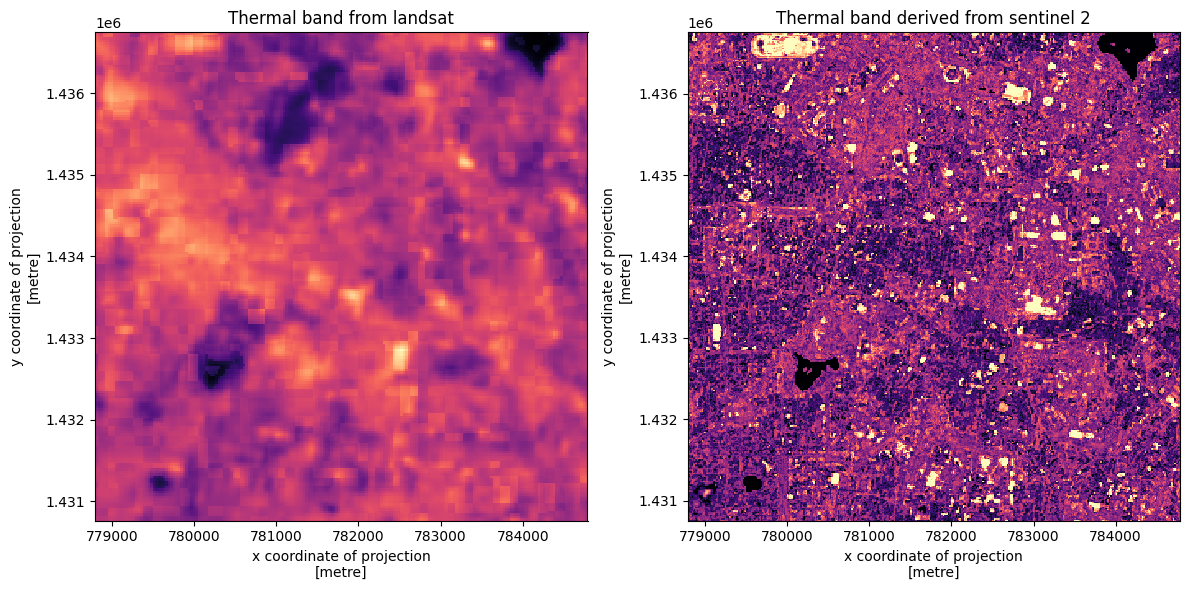

In [44]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

celsius.plot(ax=axes[0],cmap="magma", add_colorbar=False)
axes[0].set_title("Thermal band from landsat")

celsius1.plot(ax=axes[1],cmap="magma",robust=True, add_colorbar=False)
axes[1].set_title("Thermal band derived from sentinel 2")

plt.tight_layout()
plt.show()

In [ ]:
# -----------------------------
# 5. Save prediction as GeoTIFF
# -----------------------------
pred_da.rio.to_raster("xgb_prediction.tif")
print("Saved prediction to xgb_prediction.tif")